# Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset # for loading dataset (mnist)
import torchvision.transforms as transforms # for processing datasets
from torch.utils.data import DataLoader # for making dataset easier to use 

from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


# Hyper parameter setting

In [24]:
# hypter parameter setting
learning_rate = 1e-3 
epochs = 30
display_step = 10 
batch_size = 32

activation = nn.ReLU()
max_pool = nn.MaxPool2d(2,2) # kerel size, stride size, padding size 

# Load data & Pre-process data

len(train_data):  60000
len(test_data):  10000
data tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
     

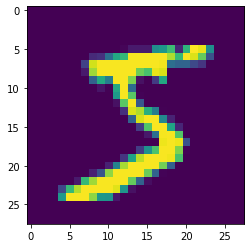

data shape: torch.Size([32, 1, 28, 28])
label: tensor([2, 7, 0, 3, 1, 5, 4, 5, 1, 1, 3, 5, 6, 5, 8, 5, 1, 9, 1, 5, 5, 1, 0, 8,
        3, 7, 7, 3, 0, 4, 0, 3])


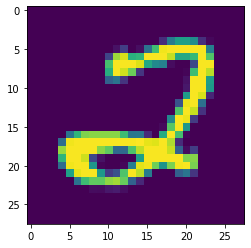

In [25]:
# load data
train_data = dataset.MNIST("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.MNIST("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('data', x_train)
print('data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

# Model & Optimization and Loss function

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() 
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  
            nn.BatchNorm2d(16),
            activation,          
            
            nn.Conv2d(16, 32,3, padding=1),
            nn.BatchNorm2d(32),
            activation,
            max_pool,
            
            nn.Conv2d(32,64,3, padding=1),
            nn.BatchNorm2d(64),
            activation,
            max_pool
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            activation,
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            activation,
            nn.Linear(64,10),
        )
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) 
        flatten = extracted_feature.view(batch_size, -1) 
        result = self.classifier(flatten)
        return result

model = CNN().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [31]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())

0 epoch loss: 0.40016454458236694
10 epoch loss: 0.012645549140870571
20 epoch loss: 0.015541872940957546


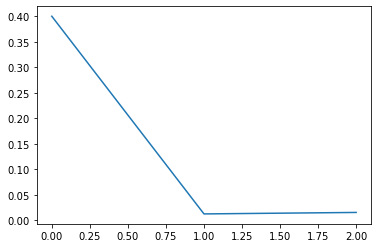

In [32]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [33]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("Accuracy of the model: {}".format(correct/total))

Accuracy of the model: 0.9926882982254028
